Included Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


In [3]:
sales_data = pd.read_csv('train.csv')
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Converting Date to Date_time and extracting features

In [4]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day'] = sales_data['date'].dt.day
sales_data.head()

,date,store,item,sales,year,month,day
0,2013-01-01,1,1,13,2013,1,1
1,2013-01-02,1,1,11,2013,1,2
2,2013-01-03,1,1,14,2013,1,3
3,2013-01-04,1,1,13,2013,1,4
4,2013-01-05,1,1,10,2013,1,5


 Create lag features for the past 12 months

In [5]:
for i in range(1, 13):
    sales_data[f'lag_{i}'] = sales_data['sales'].shift(i)

Drop rows with NaN values created by lagging

In [6]:
sales_data.dropna(inplace=True)

In [7]:
sales_data.head()

,date,store,item,sales,year,month,day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
12,2013-01-13,1,1,10,2013,1,13,7.0,9.0,9.0,12.0,9.0,10.0,12.0,10.0,13.0,14.0,11.0,13.0
13,2013-01-14,1,1,12,2013,1,14,10.0,7.0,9.0,9.0,12.0,9.0,10.0,12.0,10.0,13.0,14.0,11.0
14,2013-01-15,1,1,5,2013,1,15,12.0,10.0,7.0,9.0,9.0,12.0,9.0,10.0,12.0,10.0,13.0,14.0
15,2013-01-16,1,1,7,2013,1,16,5.0,12.0,10.0,7.0,9.0,9.0,12.0,9.0,10.0,12.0,10.0,13.0
16,2013-01-17,1,1,16,2013,1,17,7.0,5.0,12.0,10.0,7.0,9.0,9.0,12.0,9.0,10.0,12.0,10.0


In [8]:
features = ['store', 'item', 'year', 'month', 'day'] + [f'lag_{i}' for i in range(1, 13)]
X = sales_data[features]
y = sales_data['sales']

Correlation Matrix

In [9]:
corr_matrix = sales_data[features + ['sales']].corr()

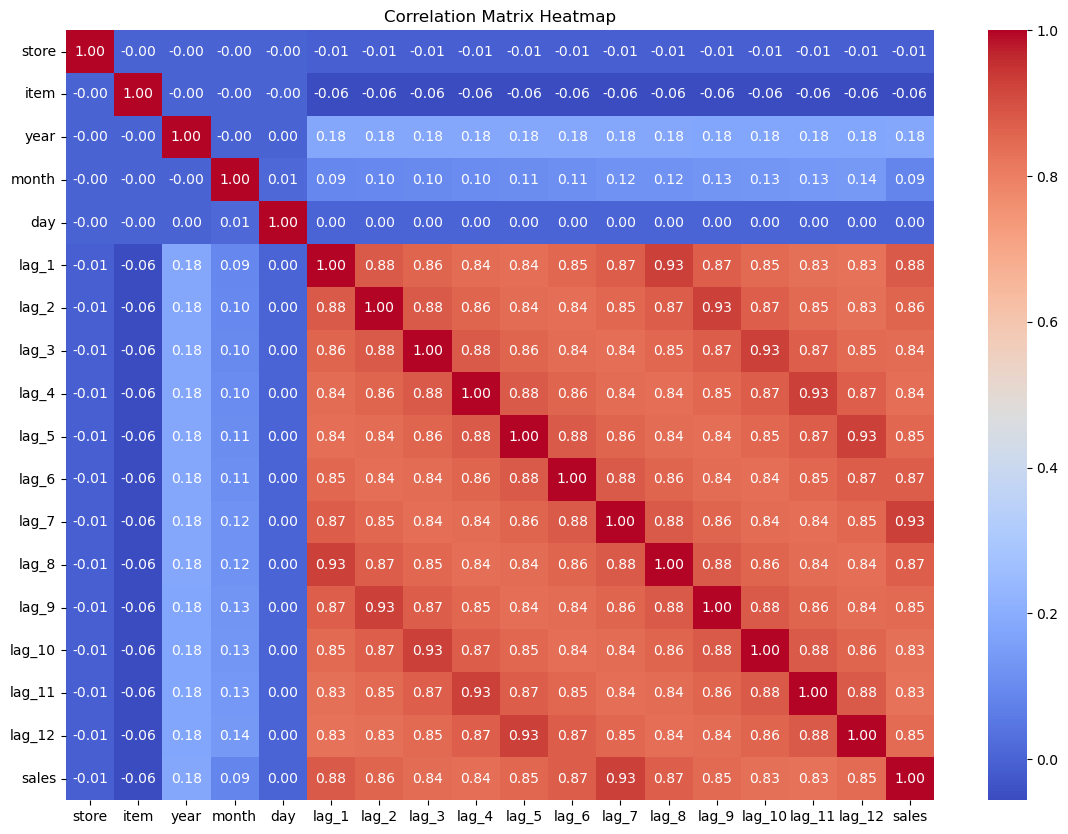

In [10]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Finding two features with highest correlation

In [11]:
best_features = corr_matrix['sales'].drop('sales').abs().nlargest(2).index

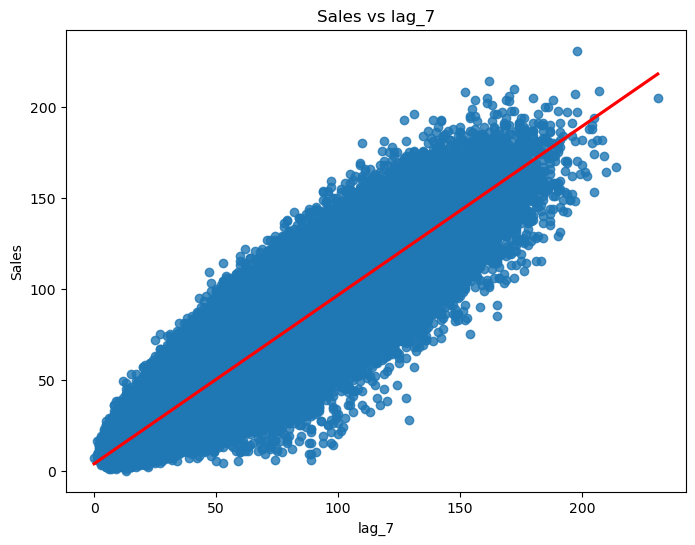

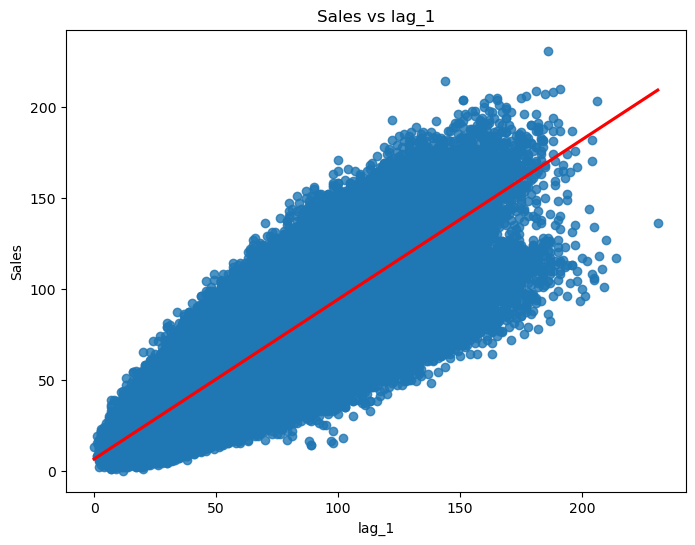

In [12]:
for feature in best_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=sales_data[feature], y=y, line_kws={"color": "red"})
    plt.title(f'Sales vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Sales')
    plt.show()

Yearly Sales Plot

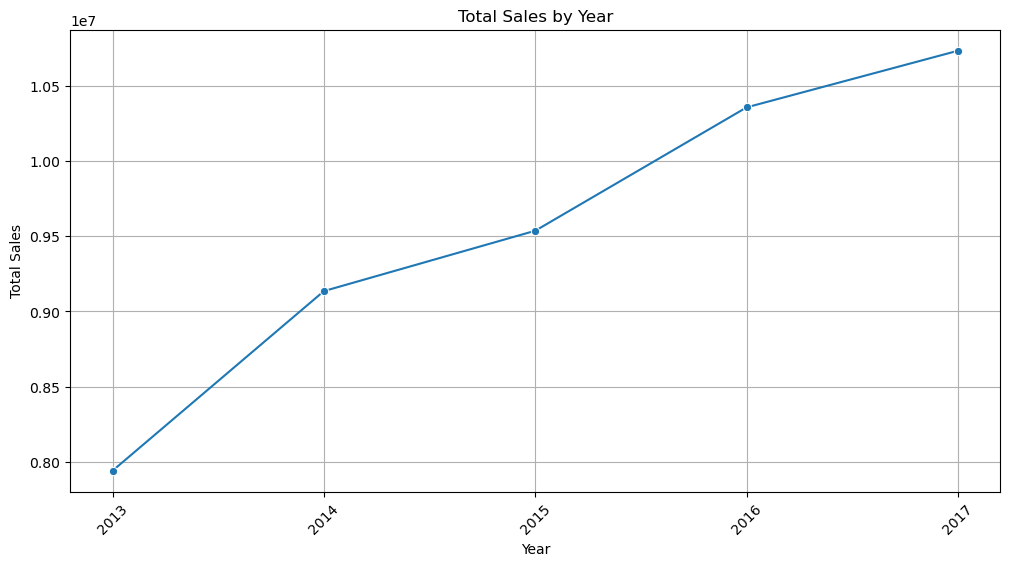

In [14]:
yearly_sales = sales_data.groupby('year')['sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_sales, x='year', y='sales', marker='o')
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.xticks(yearly_sales['year'], rotation=45) 
plt.grid()
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [17]:
rf_model = RandomForestRegressor(
    n_estimators=100,  
    max_depth=10,     
    n_jobs=-1,         
    random_state=42
)

gb_model = GradientBoostingRegressor(
    n_estimators=100, 
    max_depth=3,       
    subsample=0.8,     
    random_state=42
)

In [18]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

In [19]:
def percentage_error(y_true, y_pred):
    
    non_zero_indices = y_true != 0
    if not np.any(non_zero_indices):
        return np.inf  
    return np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100

In [20]:
def calculate_accuracy(y_true, y_pred):
    percentage_error_value = percentage_error(y_true, y_pred)
    if percentage_error_value == np.inf:
        return 0  
    return 100 - percentage_error_value

percentage_error_scorer = make_scorer(percentage_error, greater_is_better=False)

Evaluating without K-Fold

In [21]:
all_metrics = {}

print("Evaluation without K-Fold:")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)  
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    percentage_error_value = percentage_error(y_test, predictions)
    accuracy = calculate_accuracy(y_test, predictions)
    
    # Store metrics in the dictionary
    all_metrics[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'Percentage Error': percentage_error_value,
        'Accuracy': accuracy
    }
    
    print(f"{name} Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")  # Print RMSE
    print(f"R² Score: {r2:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Percentage Error: {percentage_error_value:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%\n")

Evaluation without K-Fold:
Linear Regression Evaluation:
Mean Squared Error (MSE): 91.06
Root Mean Squared Error (RMSE): 9.54
R² Score: 0.89
Mean Absolute Error (MAE): 7.27
Percentage Error: 17.05%
Accuracy: 82.95%

Decision Tree Evaluation:
Mean Squared Error (MSE): 147.82
Root Mean Squared Error (RMSE): 12.16
R² Score: 0.82
Mean Absolute Error (MAE): 9.29
Percentage Error: 21.81%
Accuracy: 78.19%

Random Forest Evaluation:
Mean Squared Error (MSE): 77.09
Root Mean Squared Error (RMSE): 8.78
R² Score: 0.91
Mean Absolute Error (MAE): 6.72
Percentage Error: 16.05%
Accuracy: 83.95%

Gradient Boosting Evaluation:
Mean Squared Error (MSE): 78.71
Root Mean Squared Error (RMSE): 8.87
R² Score: 0.91
Mean Absolute Error (MAE): 6.80
Percentage Error: 16.15%
Accuracy: 83.85%



Evaluating with K-fold

In [22]:
kf = KFold(n_splits=2, shuffle=True, random_state=42)


print("Evaluation with K-Fold:")
for name, model in models.items():
    mse_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='r2')
    mae_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_absolute_error')
    percentage_error_scores = cross_val_score(model, X_scaled, y, cv=kf, scoring=percentage_error_scorer)
    accuracy_scores = 100 + percentage_error_scores  
    
    rmse = np.sqrt(-np.mean(mse_scores))  

    print(f"{name} Cross-Validation Evaluation:")
    print(f"Mean Squared Error (MSE): {-np.mean(mse_scores):.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")  # Print RMSE
    print(f"R² Score: {np.mean(r2_scores):.2f}")
    print(f"Mean Absolute Error (MAE): {-np.mean(mae_scores):.2f}")
    print(f"Percentage Error: {-np.mean(percentage_error_scores):.2f}%")
    print(f"Accuracy: {np.mean(accuracy_scores):.2f}%\n")

Evaluation with K-Fold:
Linear Regression Cross-Validation Evaluation:
Mean Squared Error (MSE): 90.97
Root Mean Squared Error (RMSE): 9.54
R² Score: 0.89
Mean Absolute Error (MAE): 7.26
Percentage Error: 17.01%
Accuracy: 82.99%

Decision Tree Cross-Validation Evaluation:
Mean Squared Error (MSE): 149.57
Root Mean Squared Error (RMSE): 12.23
R² Score: 0.82
Mean Absolute Error (MAE): 9.35
Percentage Error: 21.96%
Accuracy: 78.04%

Random Forest Cross-Validation Evaluation:
Mean Squared Error (MSE): 76.78
Root Mean Squared Error (RMSE): 8.76
R² Score: 0.91
Mean Absolute Error (MAE): 6.70
Percentage Error: 16.00%
Accuracy: 84.00%

Gradient Boosting Cross-Validation Evaluation:
Mean Squared Error (MSE): 78.53
Root Mean Squared Error (RMSE): 8.86
R² Score: 0.91
Mean Absolute Error (MAE): 6.79
Percentage Error: 16.11%
Accuracy: 83.89%



First Stacking Model

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

base_models_1 = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]

meta_model_1 = RandomForestRegressor(
    n_estimators=100,  
    max_depth=10,     
    n_jobs=-1,         
    random_state=42
)

stacking_model_1 = StackingRegressor(estimators=base_models_1, final_estimator=meta_model_1, cv=5)

stacking_model_1.fit(X_train_scaled, y_train)

stacking_predictions_1 = stacking_model_1.predict(X_test_scaled)

In [24]:
mse_stacking_1 = mean_squared_error(y_test, stacking_predictions_1)
rmse_stacking_1 = np.sqrt(mse_stacking_1)  # Calculate RMSE
r2_stacking_1 = r2_score(y_test, stacking_predictions_1)
mae_stacking_1 = mean_absolute_error(y_test, stacking_predictions_1)

percentage_error_stacking_1 = percentage_error(y_test, stacking_predictions_1)
accuracy_stacking_1 = 100 - percentage_error_stacking_1  # Convert to accuracy

all_metrics['First Stacking Model'] = {
    'MSE': mse_stacking_1,
    'RMSE': rmse_stacking_1,  
    'R²': r2_stacking_1,
    'MAE': mae_stacking_1,
    'Percentage Error': percentage_error_stacking_1,
    'Accuracy': accuracy_stacking_1
}

print("First Stacking Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_stacking_1:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacking_1:.2f}")  # Print RMSE
print(f"R² Score: {r2_stacking_1:.2f}")
print(f"Mean Absolute Error (MAE): {mae_stacking_1:.2f}")
print(f"Percentage Error: {percentage_error_stacking_1:.2f}%")
print(f"Accuracy: {accuracy_stacking_1:.2f}%")

First Stacking Model Evaluation:
Mean Squared Error (MSE): 85.94
Root Mean Squared Error (RMSE): 9.27
R² Score: 0.90
Mean Absolute Error (MAE): 7.08
Percentage Error: 16.78%
Accuracy: 83.22%


Second Stacking Model

In [25]:
base_models_2 = [
    ('rf', RandomForestRegressor(
    n_estimators=100,  
    max_depth=10,      
    n_jobs=-1,         
    random_state=42
)),
    ('gb',GradientBoostingRegressor(
    n_estimators=100,  
    max_depth=3,      
    subsample=0.8,     
    random_state=42
))
]

meta_model_2 = LinearRegression()

stacking_model_2 = StackingRegressor(estimators=base_models_2, final_estimator=meta_model_2, cv=5)
stacking_model_2.fit(X_train_scaled, y_train)
stacking_predictions_2 = stacking_model_2.predict(X_test_scaled)

In [26]:
mse_stacking_2 = mean_squared_error(y_test, stacking_predictions_2)
rmse_stacking_2 = np.sqrt(mse_stacking_2)  # Calculate RMSE
r2_stacking_2 = r2_score(y_test, stacking_predictions_2)
mae_stacking_2 = mean_absolute_error(y_test, stacking_predictions_2)

percentage_error_stacking_2 = percentage_error(y_test, stacking_predictions_2)
accuracy_stacking_2 = 100 - percentage_error_stacking_2  

all_metrics['Second Stacking Model'] = {
    'MSE': mse_stacking_2,
    'RMSE': rmse_stacking_2,  
    'R²': r2_stacking_2,
    'MAE': mae_stacking_2,
    'Percentage Error': percentage_error_stacking_2,
    'Accuracy': accuracy_stacking_2
}

print("Second Stacking Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_stacking_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacking_2:.2f}")  # Print RMSE
print(f"R² Score: {r2_stacking_2:.2f}")
print(f"Mean Absolute Error (MAE): {mae_stacking_2:.2f}")
print(f"Percentage Error: {percentage_error_stacking_2:.2f}%")
print(f"Accuracy: {accuracy_stacking_2:.2f}%")

Second Stacking Model Evaluation:
Mean Squared Error (MSE): 75.64
Root Mean Squared Error (RMSE): 8.70
R² Score: 0.91
Mean Absolute Error (MAE): 6.66
Percentage Error: 15.81%
Accuracy: 84.19%


LSTM (Long Short-Term Memory)

In [32]:
!pip install tensorflow
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming X and y are already defined and standardized
# X is your feature set and y is your target variable

# Step 1: Create sequences for LSTM
def create_sequences(data, target, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Define time steps
time_steps = 12  # For example, using the past 12 months

# Create sequences for LSTM
X_sequences, y_sequences = create_sequences(X_scaled, y.values, time_steps)

# Reshape input to be [samples, time steps, features]
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2]))

# # Step 2: Build LSTM model
# lstm_model = Sequential()
# lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_sequences.shape[1], X_sequences.shape[2])))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(LSTM(50, return_sequences=False))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(Dense(1))  # Output layer for regression

# # Step 3: Compile the model
# lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# # Step 4: Fit the model
# lstm_model.fit(X_sequences, y_sequences, epochs=50, batch_size=32)




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# lstm_model.save('my_lstm_model.h5')

In [34]:
from tensorflow.keras.models import load_model
# Load the model
lstm_model = load_model('my_lstm_model.h5')

In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Step 5: Make predictions
predictions = lstm_model.predict(X_sequences)

# Convert predictions and y_sequences to float32 to save memory
y_sequences = y_sequences.astype(np.float32)
predictions = predictions.astype(np.float32)

# Step 6: Evaluate the model in batches
batch_size = 1000  # Adjust based on your memory capacity
mse_list = []
rmse_list = []
r2_list = []
mae_list = []
percentage_error_values = []
accuracy_list = []

for i in range(0, len(y_sequences), batch_size):
    y_batch = y_sequences[i:i + batch_size]
    pred_batch = predictions[i:i + batch_size]

    mse = mean_squared_error(y_batch, pred_batch)
    mse_list.append(mse)
    rmse_list.append(np.sqrt(mse))  # Calculate RMSE for the batch
    r2_list.append(r2_score(y_batch, pred_batch))
    mae_list.append(mean_absolute_error(y_batch, pred_batch))
    percentage_error_values.append(percentage_error(y_batch, pred_batch))
    accuracy_list.append(100 - percentage_error(y_batch, pred_batch))  # Calculate accuracy for the batch

# Average the results
mse = np.mean(mse_list)
rmse = np.sqrt(mse)  # Calculate overall RMSE
r2 = np.mean(r2_list)
mae = np.mean(mae_list)
percentage_error_value = np.mean(percentage_error_values)
accuracy = np.mean(accuracy_list)  # Average accuracy

# Store metrics in the all_metrics dictionary
all_metrics['LSTM Model'] = {
    'MSE': mse,
    'RMSE': rmse,  # Store RMSE
    'R²': r2,
    'MAE': mae,
    'Percentage Error': percentage_error_value,
    'Accuracy': accuracy
}

# Print evaluation results
print("LSTM Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")  # Print RMSE
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Percentage Error: {percentage_error_value:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

28531/28531 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step
LSTM Model Evaluation:
Mean Squared Error (MSE): 55.96
Root Mean Squared Error (RMSE): 7.48
R² Score: 0.70
Mean Absolute Error (MAE): 5.78
Percentage Error: 35.95%
Accuracy: 64.05%


Plotting the comparison Bar Graph for the evaluation metrics

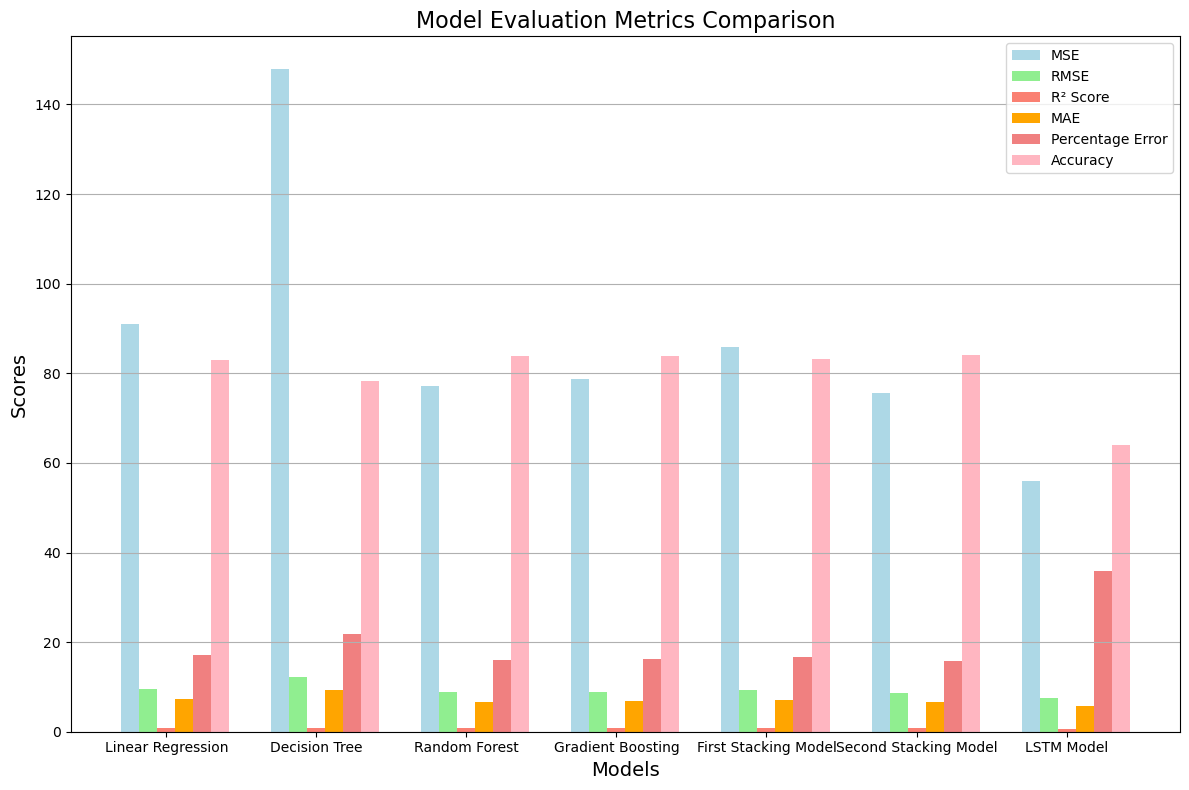

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define the model names, including two stacked models
models = list(all_metrics.keys())

# Extract evaluation metrics for each model from the all_metrics dictionary
mse = [all_metrics[model]['MSE'] for model in models]
rmse = [all_metrics[model]['RMSE'] for model in models]  # Extract RMSE values
r2 = [all_metrics[model]['R²'] for model in models]
mae = [all_metrics[model]['MAE'] for model in models]
percentage_error = [all_metrics[model]['Percentage Error'] for model in models]
accuracy = [all_metrics[model]['Accuracy'] for model in models]

# Create a bar graph
bar_width = 0.12
x = np.arange(len(models))

# Plot each metric
plt.figure(figsize=(12, 8))

plt.bar(x - 2*bar_width, mse, width=bar_width, label='MSE', color='lightblue')
plt.bar(x - bar_width, rmse, width=bar_width, label='RMSE', color='lightgreen')  # Add RMSE
plt.bar(x, r2, width=bar_width, label='R² Score', color='salmon')
plt.bar(x + bar_width, mae, width=bar_width, label='MAE', color='orange')
plt.bar(x + 2*bar_width, percentage_error, width=bar_width, label='Percentage Error', color='lightcoral')
plt.bar(x + 3*bar_width, accuracy, width=bar_width, label='Accuracy', color='lightpink')  # Add Accuracy

# Add labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Model Evaluation Metrics Comparison', fontsize=16)
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()